In [4]:
# LSEG/Refinitive Data Acquisition of Required Data
#Target Period: 2006-01-01 to 2025-06-30

#Imports
#Import Refinitiv data library for data acquisition
import pandas as pd
import numpy as np
import yfinance as yf
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing as hp

In [5]:
"""
#Start Refinitiv Session
rd.open_session(app_key="2ad05903f7cb4f84b75e13735fb71abde98f7d85")
"""

'\n#Start Refinitiv Session\nrd.open_session(app_key="2ad05903f7cb4f84b75e13735fb71abde98f7d85")\n'

In [6]:
"""
#Define instruments and Date range
START_DATE = "2006-01-01"
END_DATE = "2025-06-30"

# Replace these placeholders with the actual Refinitiv RICs 
SPX_PROXY_RIC     = "SPY.P"   # S&P 500 ETF (proxy for .SPX)
DOLLAR_INDEX_RIC  = ".DXY"    # Dollar Index
WTI_OIL_RIC       = "CLc1"    # WTI Crude Oil Futures (continuous contract)
"""

'\n#Define instruments and Date range\nSTART_DATE = "2006-01-01"\nEND_DATE = "2025-06-30"\n\n# Replace these placeholders with the actual Refinitiv RICs \nSPX_PROXY_RIC     = "SPY.P"   # S&P 500 ETF (proxy for .SPX)\nDOLLAR_INDEX_RIC  = ".DXY"    # Dollar Index\nWTI_OIL_RIC       = "CLc1"    # WTI Crude Oil Futures (continuous contract)\n'

In [10]:
#import refinitiv.data as rd
#print("Refinitiv Data Library version:", rd.__version__)

In [12]:
#print(dir(hp))

In [14]:
"""
from refinitiv.data.content import pricing

# request latest snapshot for Apple
snap = pricing.Definition(universe="AAPL.O").get_data()
print(snap)
"""

'\nfrom refinitiv.data.content import pricing\n\n# request latest snapshot for Apple\nsnap = pricing.Definition(universe="AAPL.O").get_data()\nprint(snap)\n'

In [16]:
"""
#Obtain required data
# --- 1. S&P 500 OHLCV ---
df_spx_raw = hp.summaries.Definition(
    universe=SPX_PROXY_RIC,
    fields=["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"],
    interval=hp.Intervals.DAILY,
    start=START_DATE,
    end=END_DATE
).get_data()

# --- 2. Dollar Index & WTI Oil (Closing Prices) ---
df_macro_raw = hp.summaries.Definition(
    universe=[DOLLAR_INDEX_RIC, WTI_OIL_RIC],
    fields=["CLOSE"],
    interval=hp.Intervals.DAILY,
    start=START_DATE,
    end=END_DATE
).get_data()

# Output checks
print("S&P 500 Raw DataFrame (df_spx_raw):")
print(df_spx_raw.head())

print("\nMacro Raw DataFrame (df_macro_raw):")
print(df_macro_raw.head())
"""

'\n#Obtain required data\n# --- 1. S&P 500 OHLCV ---\ndf_spx_raw = hp.summaries.Definition(\n    universe=SPX_PROXY_RIC,\n    fields=["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"],\n    interval=hp.Intervals.DAILY,\n    start=START_DATE,\n    end=END_DATE\n).get_data()\n\n# --- 2. Dollar Index & WTI Oil (Closing Prices) ---\ndf_macro_raw = hp.summaries.Definition(\n    universe=[DOLLAR_INDEX_RIC, WTI_OIL_RIC],\n    fields=["CLOSE"],\n    interval=hp.Intervals.DAILY,\n    start=START_DATE,\n    end=END_DATE\n).get_data()\n\n# Output checks\nprint("S&P 500 Raw DataFrame (df_spx_raw):")\nprint(df_spx_raw.head())\n\nprint("\nMacro Raw DataFrame (df_macro_raw):")\nprint(df_macro_raw.head())\n'

In [20]:
#Define instruments and Date range
start = "2006-01-01"
end = "2025-06-30"

# S&P500 ETF (proxy)
df_spx_raw = yf.download("SPY", start=start, end=end)

# Dollar Index (Yahoo ticker: DX-Y.NYB)
df_dxy = yf.download("DX-Y.NYB", start=start, end=end)

# WTI Oil Futures (Yahoo ticker: CL=F)
df_wti = yf.download("CL=F", start=start, end=end)

print(df_spx_raw.head())
print(df_dxy.head())
print(df_wti.head())

C:\Users\josep\AppData\Local\Temp\ipykernel_41400\3065575225.py:6:FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
C:\Users\josep\AppData\Local\Temp\ipykernel_41400\3065575225.py:9:FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
C:\Users\josep\AppData\Local\Temp\ipykernel_41400\3065575225.py:12:FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2006-01-03  87.721725  87.929435  86.122381  86.676269  73256700
2006-01-04  88.137138  88.268683  87.721720  87.832499  51899600
2006-01-05  88.192513  88.337907  87.846334  88.033273  47307500
2006-01-06  88.926422  89.023352  88.178675  88.635633  62885900
2006-01-09  89.154869  89.355648  88.884850  88.912540  43527400
Price           Close       High        Low       Open   Volume
Ticker       DX-Y.NYB   DX-Y.NYB   DX-Y.NYB   DX-Y.NYB DX-Y.NYB
Date                                                           
2006-01-03  89.839996  90.940002  89.779999  90.750000        0
2006-01-04  89.139999  89.860001  89.010002  89.730003        0
2006-01-05  89.330002  89.629997  89.180000  89.269997        0
2006-01-06  88.849998  89.629997  88.800003  89.349998        0
2006-01-09  89.250000  89.449997

# Data Preprocesssing & Transformation

In [23]:
#Import required libraries
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

#Load and confirm the raw datasets
print("SPY shape:", df_spx_raw.shape)
print("DXY shape:", df_dxy.shape)
print("WTI shape:", df_wti.shape)

#Standardise column names and isolate 'Close' column
df_spx = df_spx_raw[['Close']].rename(columns={'Close': 'SPY_Close'})
df_dxy = df_dxy[['Close']].rename(columns={'Close': 'DXY_Close'})
df_wti = df_wti[['Close']].rename(columns={'Close': 'WTI_Close'})

#Merge and clean datasets
df = df_spx.join([df_dxy, df_wti], how='inner')
df = df.dropna()
print("Merged dataframe shape:", df.shape)

#Compute returns and changes
df['SPY_log_ret'] = np.log(df['SPY_Close'] / df['SPY_Close'].shift(1)) * 100
df['SPY_price_change'] = df['SPY_Close'].diff()
df['SPY_p_change'] = df['SPY_Close'].pct_change() * 100

df['DXY_ret'] = np.log(df['DXY_Close'] / df['DXY_Close'].shift(1)) * 100
df['WTI_ret'] = np.log(df['WTI_Close'] / df['WTI_Close'].shift(1)) * 100

df = df.dropna()

SPY shape: (4902, 5)
DXY shape: (4905, 5)
WTI shape: (4901, 5)
Merged dataframe shape: (4898, 3)


C:\Users\josep\anaconda3\envs\LSTM_Research_Project\Lib\site-packages\pandas\core\internals\blocks.py:395:RuntimeWarning: invalid value encountered in log


In [27]:
#Stationarity checks
#SPY log returns
adf_result = adfuller(df['SPY_log_ret'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("✅ SPY_log_ret is stationary.")
else:
    print("⚠️ SPY_log_ret may not be stationary; differencing might be needed.")


#SPY log returns
adf_result_1 = adfuller(df['DXY_ret'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("✅ DXY_ret is stationary.")
else:
    print("⚠️ DXY_ret may not be stationary; differencing might be needed.")


#SPY log returns
adf_result_2 = adfuller(df['WTI_ret'])
print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.5f}")
if adf_result[1] < 0.05:
    print("✅ WTI_ret is stationary.")
else:
    print("⚠️ WTI_ret may not be stationary; differencing might be needed.")

ADF Statistic: -17.735, p-value: 0.00000
✅ SPY_log_ret is stationary.
ADF Statistic: -17.735, p-value: 0.00000
✅ DXY_ret is stationary.
ADF Statistic: -17.735, p-value: 0.00000
✅ WTI_ret is stationary.


In [29]:
#Scale numerical features
features_to_scale = ['SPY_log_ret', 'SPY_p_change', 'DXY_ret', 'WTI_ret']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

#Check output
print("\nScaled feature sample:")
print(df_scaled[features_to_scale].head())


Scaled feature sample:
Price      SPY_log_ret SPY_p_change   DXY_ret   WTI_ret
Ticker                                                 
Date                                                   
2006-01-04    0.350243     0.345221 -1.641286  0.162449
2006-01-05    0.017921     0.011778  0.442634 -0.382598
2006-01-06    0.639286     0.636351 -1.131528  0.841038
2006-01-09    0.175110     0.169328  0.937398 -0.425558
2006-01-10    0.048860     0.042764  0.184376 -0.082461


# Adaptive Wavelet Transform (AWT) Denoising & Decomposition

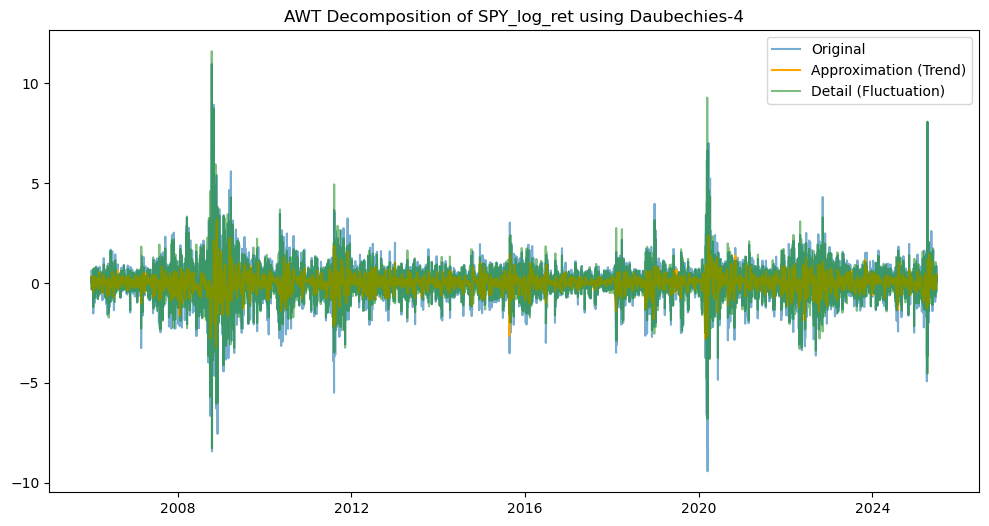


✅ AWT decomposition complete. Data saved as '03_awt_decomposed_data.csv'


In [34]:
#Import required libraries 
import pywt
import matplotlib.pyplot as plt

#1. Extract target signal
signal = df_scaled['SPY_log_ret'].values  # denoised target variable

#2. Choose wavelet parameters
wavelet = 'db4'         # Daubechies 4 is widely used in financial time series
level = 2               # decomposition level (2–4 typical for daily data)

#3. Perform discrete wavelet decomposition
coeffs = pywt.wavedec(signal, wavelet, level=level)

# where coeffs[0] = Approximation (trend), and
# coeffs[1:] = Detail coefficients (short-term fluctuations)

#4. Reconstruct the approximation and detail signals
approximation = pywt.waverec([coeffs[0]] + [None]*level, wavelet)
detail = signal - approximation[:len(signal)]  # ensure same length

# Clip both to the same index as df_scaled
approximation = approximation[:len(df_scaled)]
detail = detail[:len(df_scaled)]

#5. Add components to your DataFrame
df_scaled['SPY_s'] = approximation
df_scaled['SPY_d'] = detail

#6. Visual check of output
plt.figure(figsize=(12,6))
plt.plot(df_scaled.index, df_scaled['SPY_log_ret'], label='Original', alpha=0.6)
plt.plot(df_scaled.index, df_scaled['SPY_s'], label='Approximation (Trend)', color='orange')
plt.plot(df_scaled.index, df_scaled['SPY_d'], label='Detail (Fluctuation)', color='green', alpha=0.5)
plt.legend()
plt.title("AWT Decomposition of SPY_log_ret using Daubechies-4")
plt.show()

#7. Save the decomposed dataset
df_scaled.to_csv("03_awt_decomposed_data.csv")
print("\n✅ AWT decomposition complete. Data saved as '03_awt_decomposed_data.csv'")